In [54]:
# imports
import zipfile
import pandas as pd
import spacy
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

## Load Dataset

In [57]:
# unzip the data 
zipfile.ZipFile('../cyoa-hackathon/data/whats-cooking.zip', 'r').extractall('../cyoa-hackathon/data/')


In [58]:
zipfile.ZipFile('../cyoa-hackathon/data/test.json.zip', 'r').extractall('../cyoa-hackathon/data/')
zipfile.ZipFile('../cyoa-hackathon/data/train.json.zip', 'r').extractall('../cyoa-hackathon/data/')

In [59]:

train = pd.read_json('../cyoa-hackathon/data/train.json')
train.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


## Data Cleaning

In [61]:
train['cuisine'].value_counts()

cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: count, dtype: int64

In [62]:
train.isna().sum()

id             0
cuisine        0
ingredients    0
dtype: int64

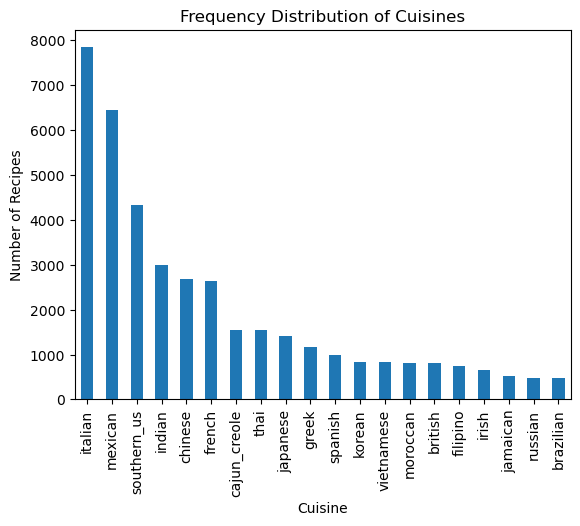

In [63]:
# distribution of cuisines
train['cuisine'].value_counts().plot(kind= 'bar')
plt.title('Frequency Distribution of Cuisines')
plt.xlabel('Cuisine')
plt.ylabel('Number of Recipes')
plt.show()

In [ ]:
#no . of classes
train['cuisine'].unique()

## Data Processing 

In [65]:

#load medium pipeline
nlp = spacy.load('en_core_web_md')

In [66]:
#train['ingredient_text']= train['ingredients'].apply(lambda x:' '.join(x).lower())
#train.head()

In [69]:
def clean_text(ingredients):
    #convert array to lower
    text = ' '.join(ingredients).lower()
    #remve numbers
    text = re.sub(r'\d+','',text)
    #remove special characters 
    text = re.sub(r'\W+',' ',text)
    doc = nlp(text)
    #Lemmatize and remove stopwords and non-alphabetic tokens
    clean_tokens = ' '.join(token.lemma_ for token in doc if token.is_alpha and not token.is_stop)
    return clean_tokens
train['ingredient_clean_text'] = train['ingredients'].apply(clean_text)


In [74]:
train.head()

,id,cuisine,ingredients,ingredient_clean_text
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",romaine lettuce black olive grape tomato garli...
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",plain flour ground pepper salt tomato ground b...
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",egg pepper salt mayonaise cook oil green chili...
3,22213,indian,"[water, vegetable oil, wheat, salt]",water vegetable oil wheat salt
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",black pepper shallot cornflour cayenne pepper ...


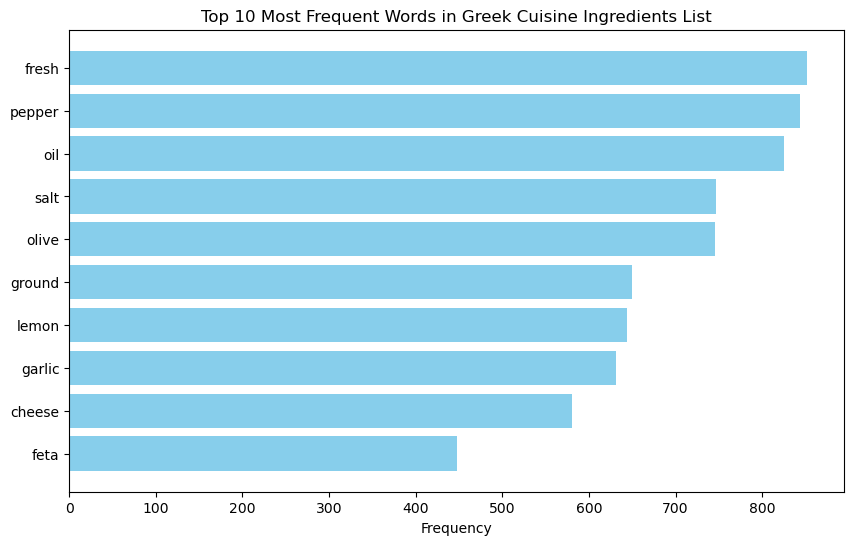

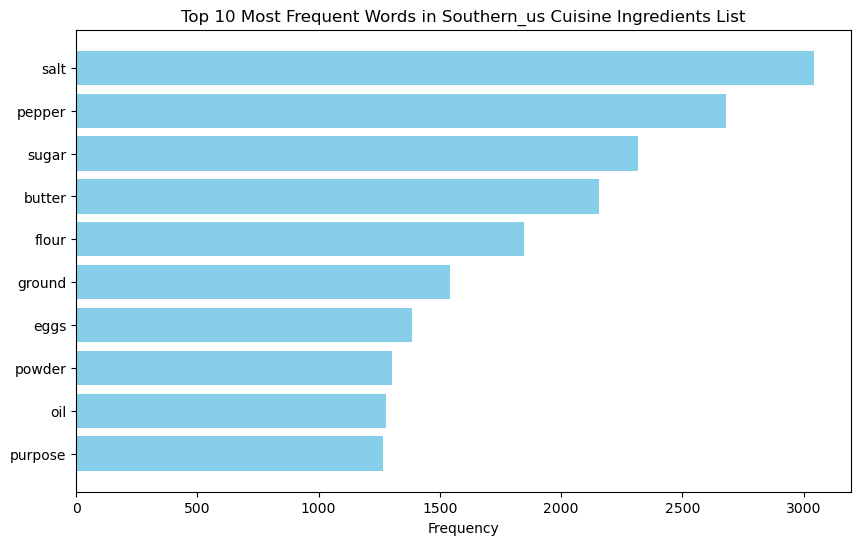

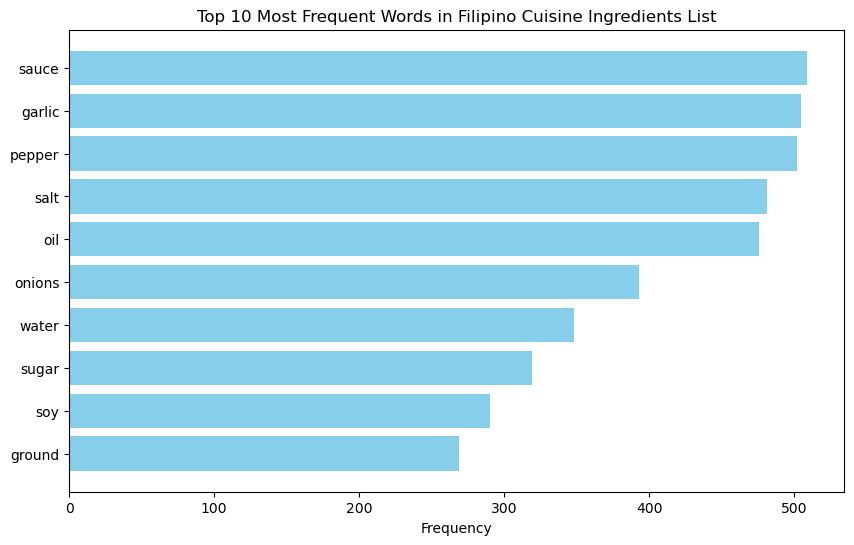

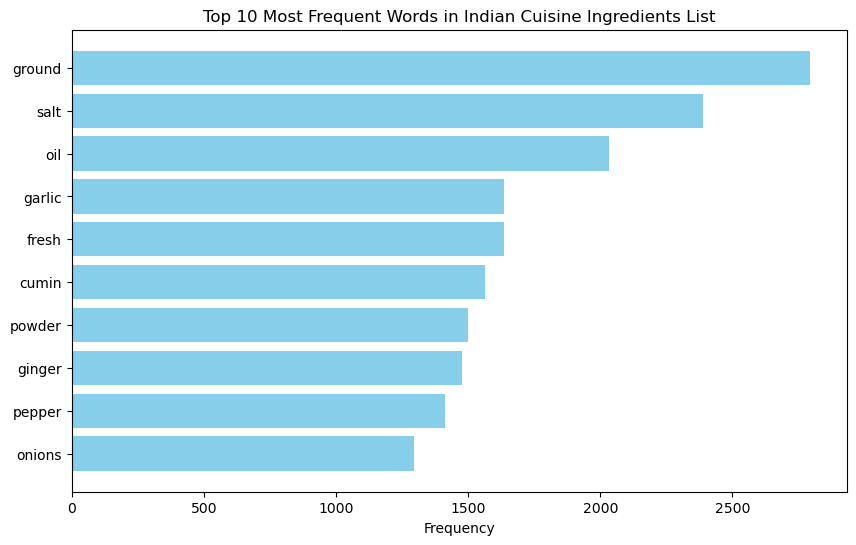

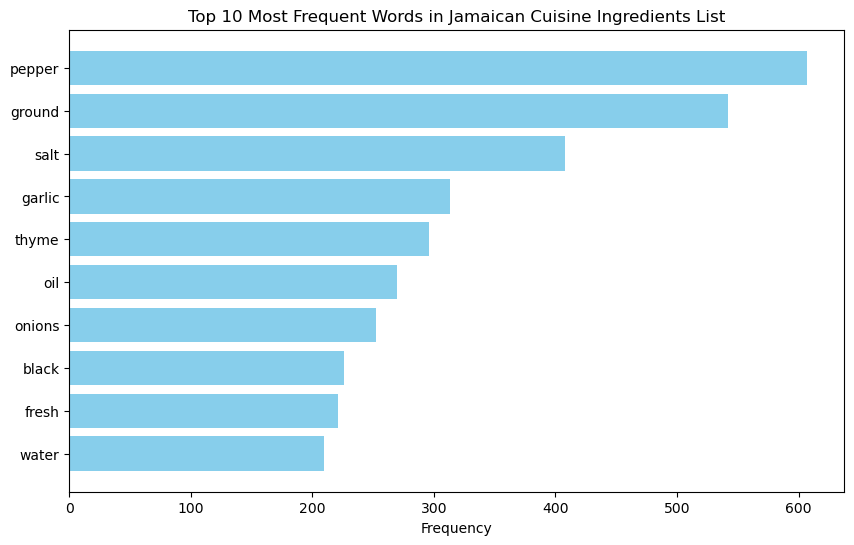

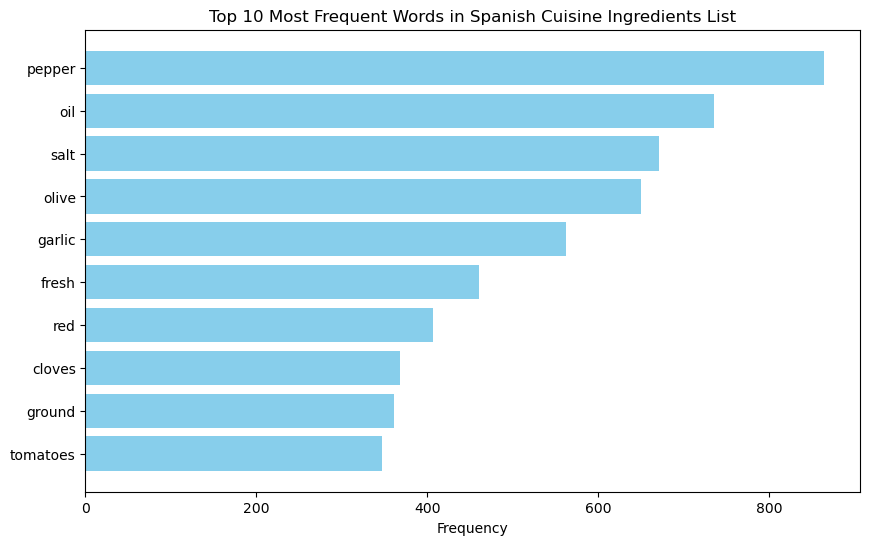

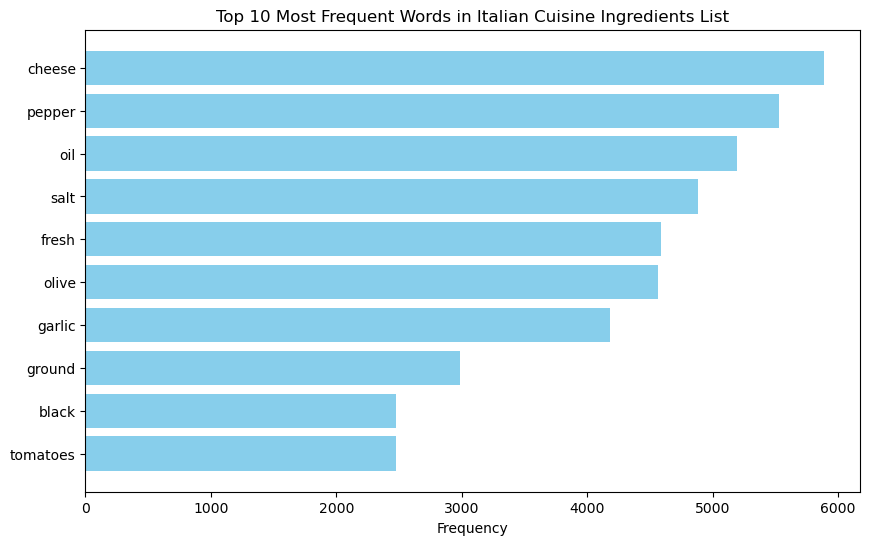

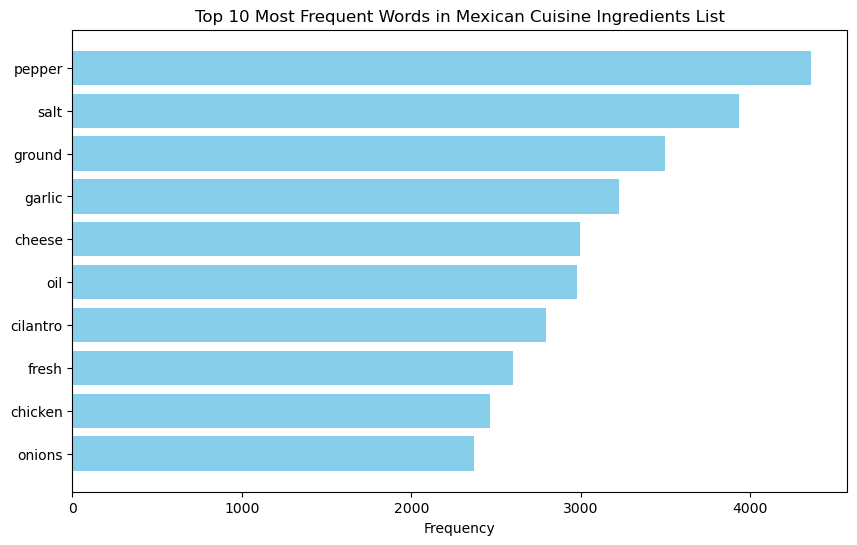

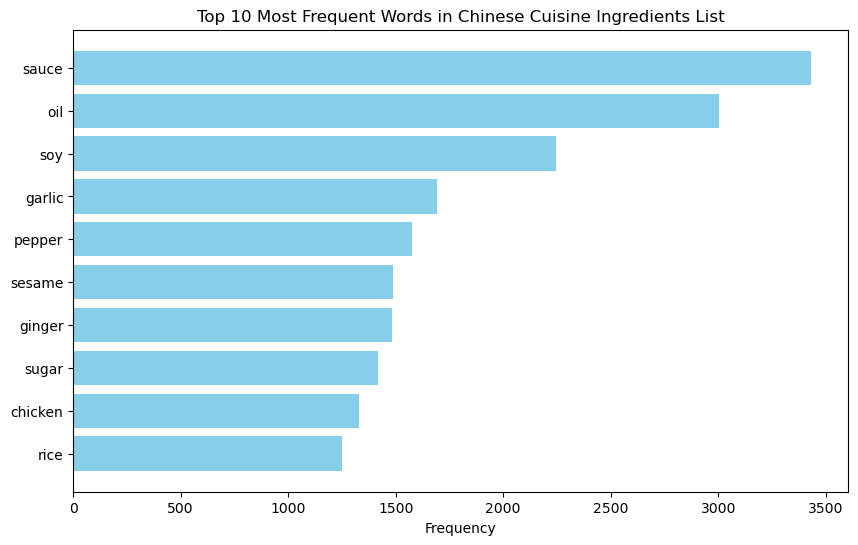

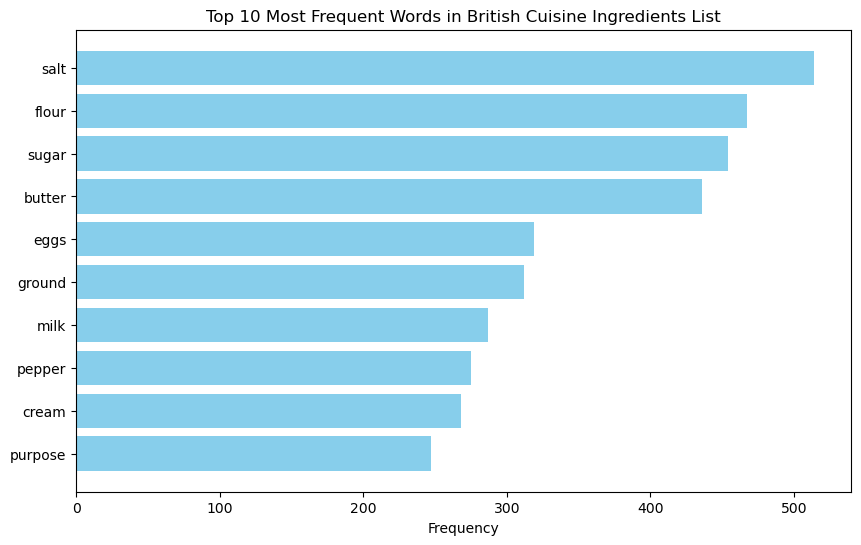

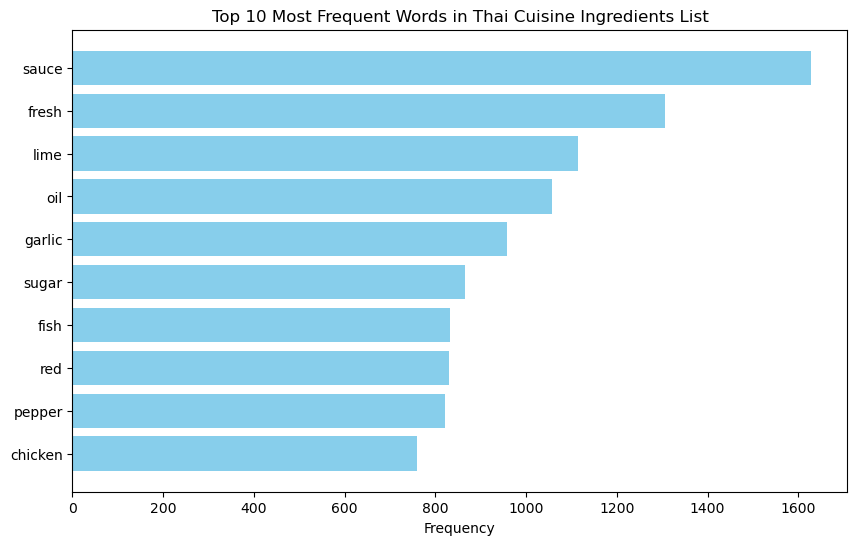

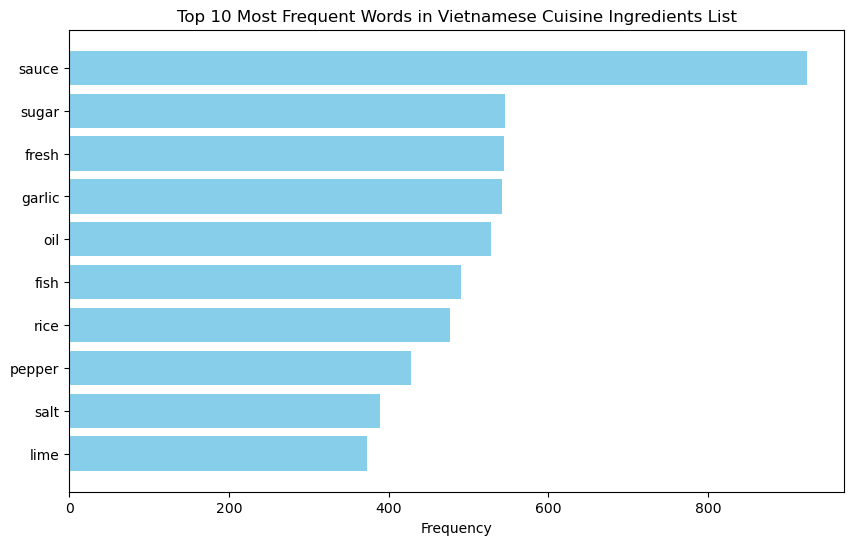

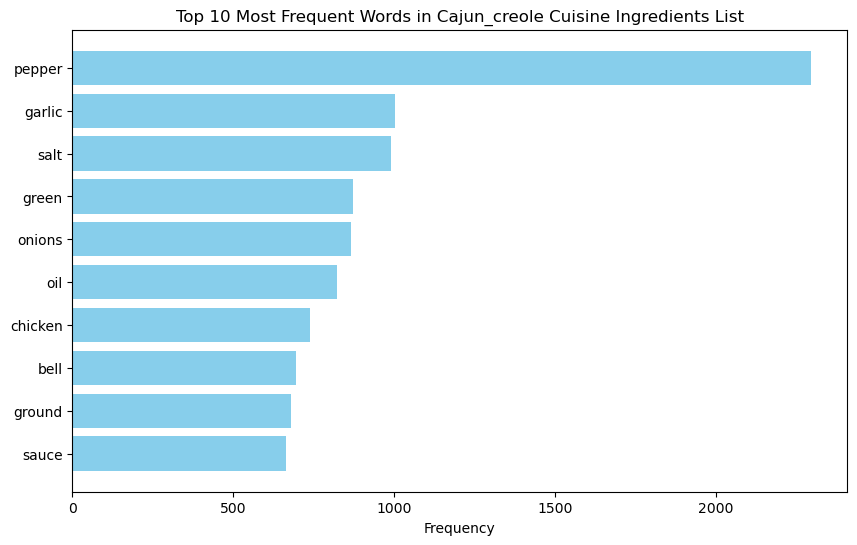

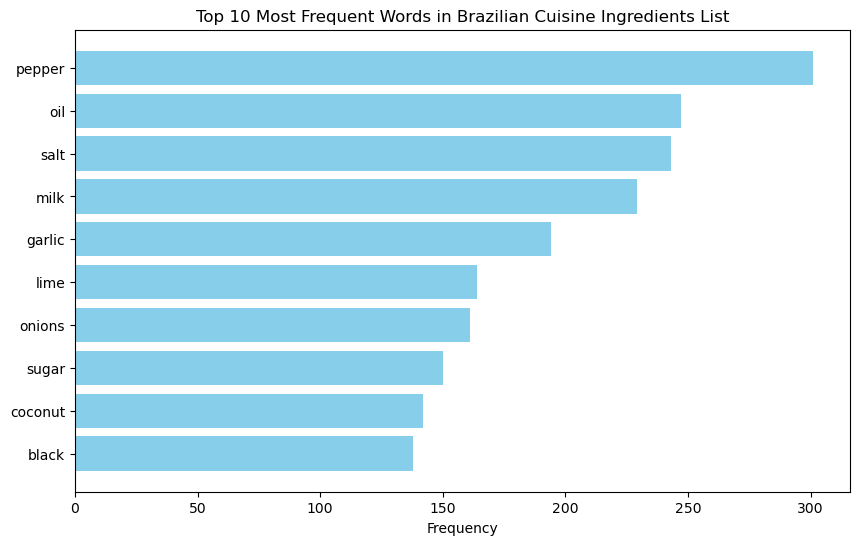

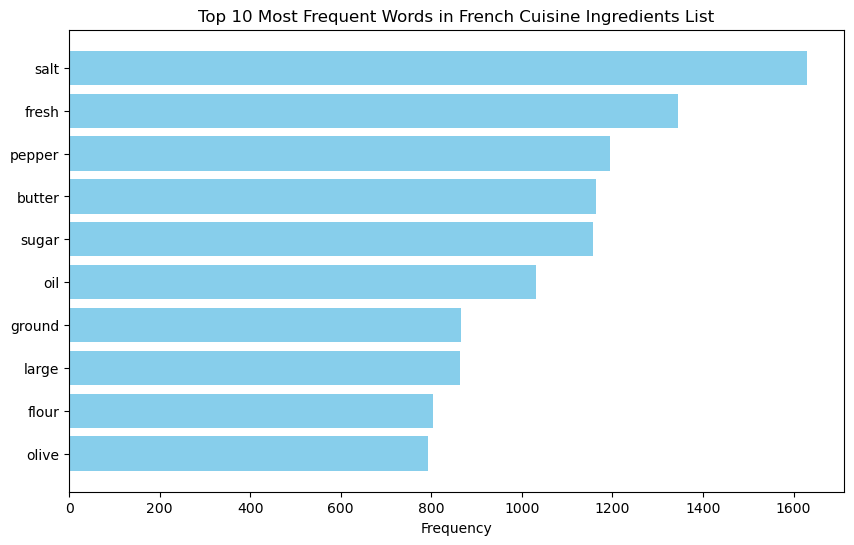

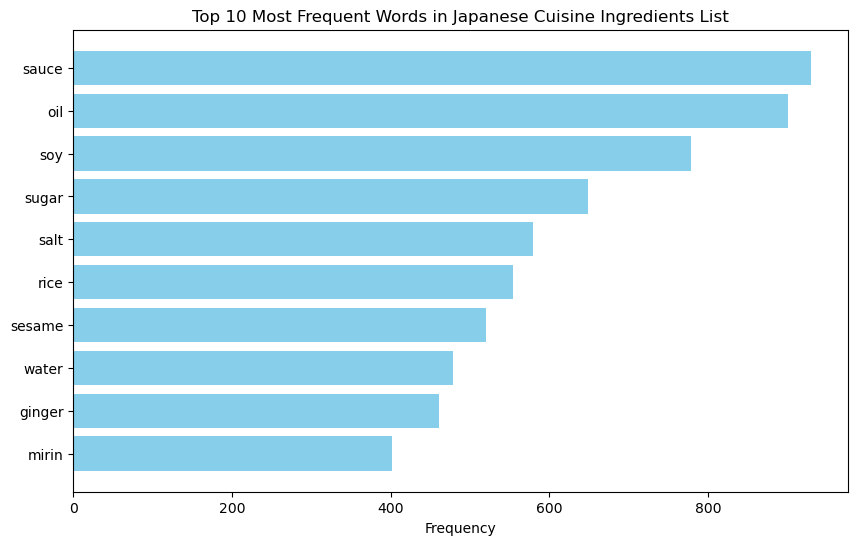

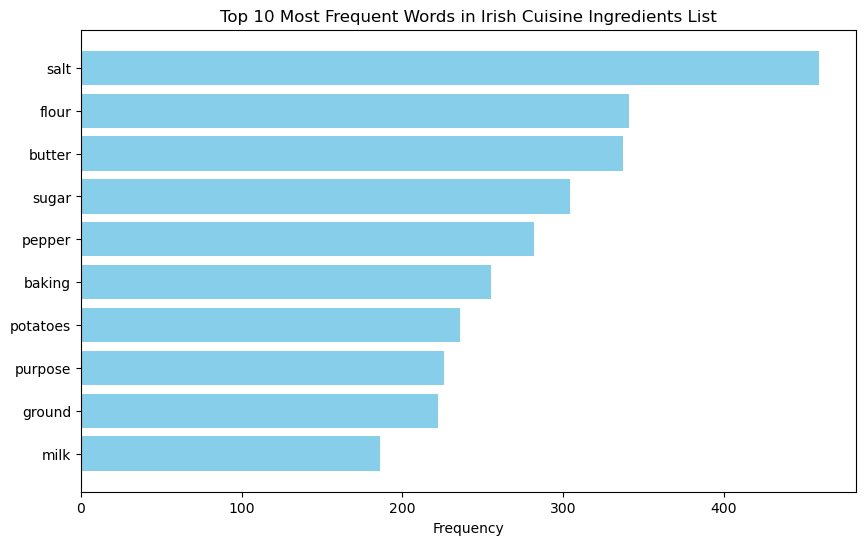

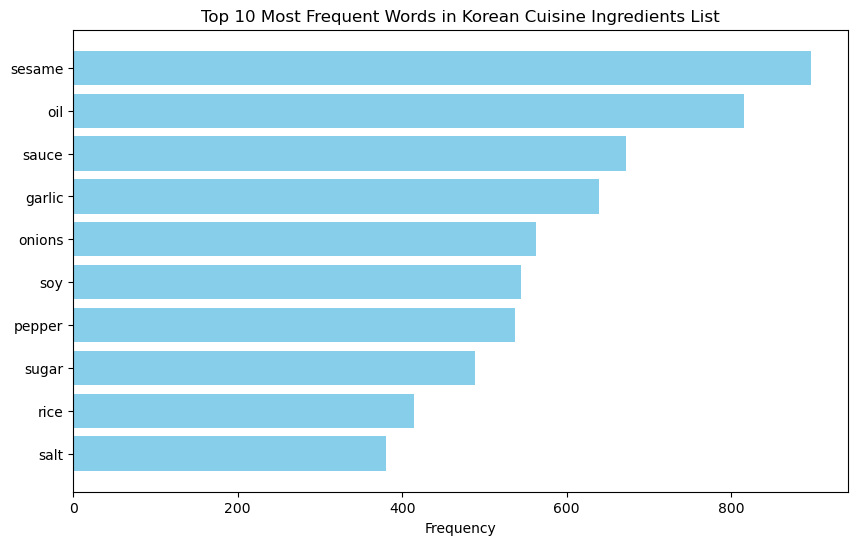

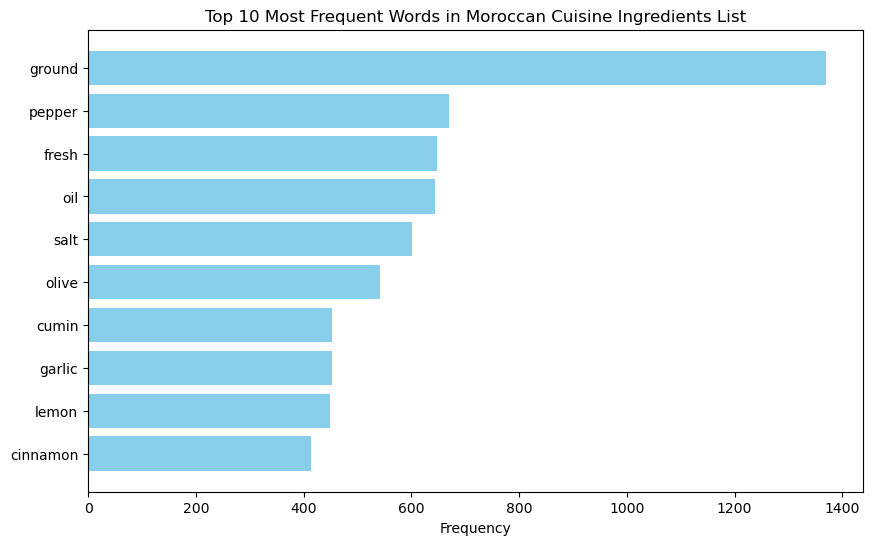

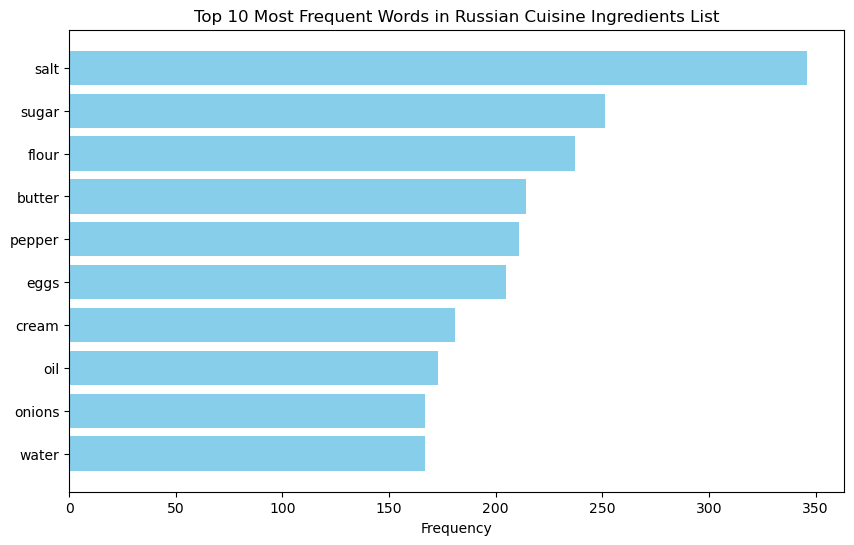

In [102]:
def get_top_words(data):
    cuisines = data['cuisine'].unique()  #unique cuisines
    results = {}

    for cuisine in cuisines:
        # Filter data for current cuisine
        filtered_data = data[data['cuisine'] == cuisine]
        
        # Combine all ingredients into one large string
        all_ingredients = ' '.join([' '.join(ingredients) for ingredients in filtered_data['ingredients']]).lower()
        
        # Use CountVectorizer to find word frequencies
        vectorizer = CountVectorizer(stop_words='english')
        vectors = vectorizer.fit_transform([all_ingredients])
        feature_names = vectorizer.get_feature_names_out()
        counts = vectors.sum(axis=0).A1
        word_freq = dict(zip(feature_names, counts))
        
        # Sort words by frequency and select the top 10
        top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:10]
        results[cuisine] = top_words

        # Plotting
        words, freqs = zip(*top_words)
        plt.figure(figsize=(10, 6))
        plt.barh(words, freqs, color='skyblue')
        plt.gca().invert_yaxis() 
        plt.xlabel('Frequency')
        plt.title(f'Top 10 Most Frequent Words in {cuisine.capitalize()} Cuisine Ingredients List')
        plt.show()

    return results
top_cuisine_words = get_top_words(train)

In [ ]:
## save processed dataset to csv file 
train.to_csv('../cyoa-hackathon/data/processed_text.csv', index=False)

In [107]:
##Predictions on test set
test = pd.read_json('../cyoa-hackathon/data/test.json')
test.head()



,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


In [109]:
test['ingredient_clean_text'] = train['ingredients'].apply(clean_text)

In [113]:
test.to_csv('../cyoa-hackathon/data/processed_text_test.csv', index=False)